In [34]:
import os
import glob
import math

import pandas as pd
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 80)

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

import seaborn as sns

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.pipeline import Pipeline

In [41]:
df = pd.read_csv("census-dataset.csv", sep=",")
df.head()

,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude
0,452600,8.3252,41,880,129,322,126,37.88,-122.23
1,358500,8.3014,21,7099,1106,2401,1138,37.86,-122.22
2,352100,7.2574,52,1467,190,496,177,37.85,-122.24
3,341300,5.6431,52,1274,235,558,219,37.85,-122.25
4,342200,3.8462,52,1627,280,565,259,37.85,-122.25


In [ ]:
df.shape()

In [38]:
df.columns

Index(['median_house_value', 'median_income', 'housing_median_age',
       'total_rooms', 'total_bedrooms', 'population', 'households', 'latitude',
       'longitude'],
      dtype='object')

In [42]:
df.describe()

,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,206855.816909,3.870671,28.639486,2635.763081,537.898014,1425.476744,499.539680,35.631861,-119.569704
std,115395.615874,1.899822,12.585558,2181.615252,421.247906,1132.462122,382.329753,2.135952,2.003532
min,14999.000000,0.499900,1.000000,2.000000,1.000000,3.000000,1.000000,32.540000,-124.350000
25%,119600.000000,2.563400,18.000000,1447.750000,295.000000,787.000000,280.000000,33.930000,-121.800000
50%,179700.000000,3.534800,29.000000,2127.000000,435.000000,1166.000000,409.000000,34.260000,-118.490000
75%,264725.000000,4.743250,37.000000,3148.000000,647.000000,1725.000000,605.000000,37.710000,-118.010000
max,500001.000000,15.000100,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,41.950000,-114.310000


In [43]:
df = df.drop(['latitude', 'longitude'], axis=1)

# Análisis exploratorio de los datos

### Valores nulos

In [44]:
null_data = df.isnull().mean()
null_data.sort_values(ascending=False)

households            0.0
population            0.0
total_bedrooms        0.0
total_rooms           0.0
housing_median_age    0.0
median_income         0.0
median_house_value    0.0
dtype: float64

### Correlación entre variables

In [45]:
corr = df.corr()
corr

,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households
median_house_value,1.000000,0.688075,0.105623,0.134153,0.050594,-0.024650,0.065843
median_income,0.688075,1.000000,-0.119034,0.198050,-0.008093,0.004834,0.013033
housing_median_age,0.105623,-0.119034,1.000000,-0.361262,-0.320485,-0.296244,-0.302916
total_rooms,0.134153,0.198050,-0.361262,1.000000,0.929893,0.857126,0.918484
total_bedrooms,0.050594,-0.008093,-0.320485,0.929893,1.000000,0.878026,0.979829
population,-0.024650,0.004834,-0.296244,0.857126,0.878026,1.000000,0.907222
households,0.065843,0.013033,-0.302916,0.918484,0.979829,0.907222,1.000000


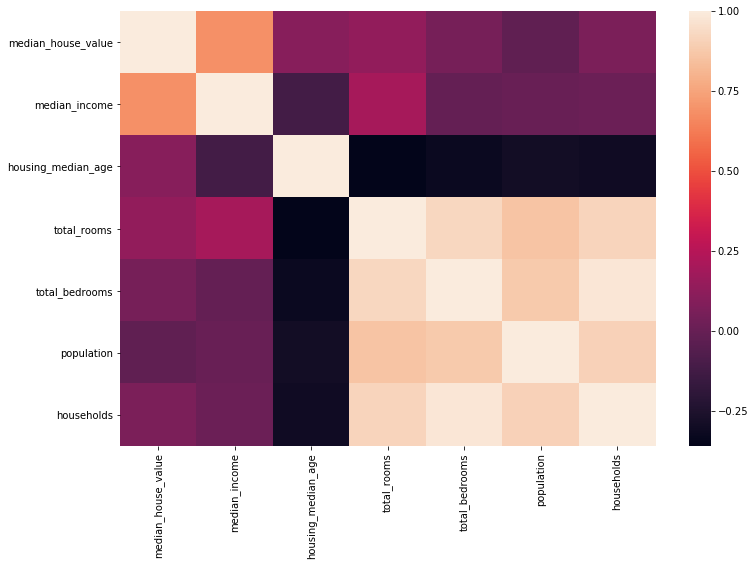

In [46]:
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

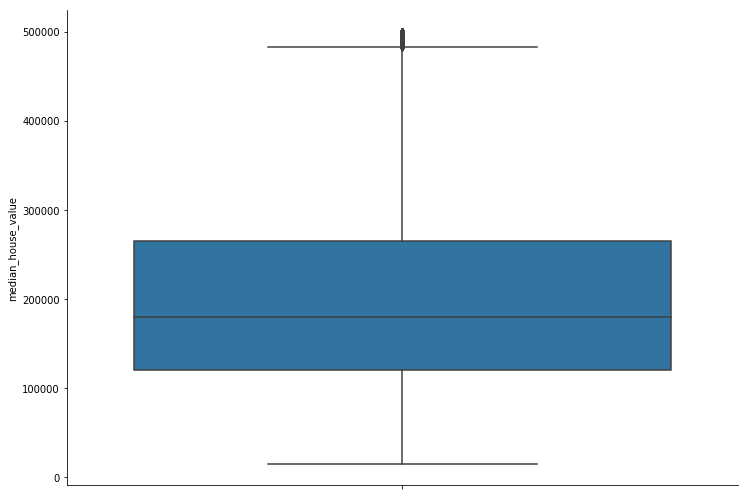

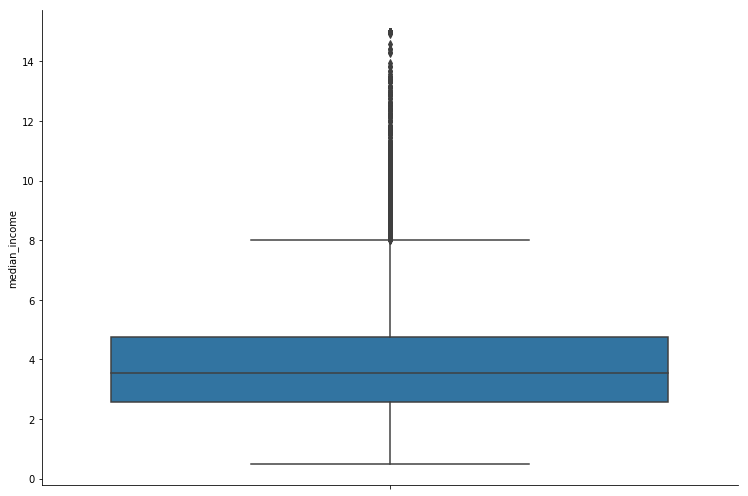

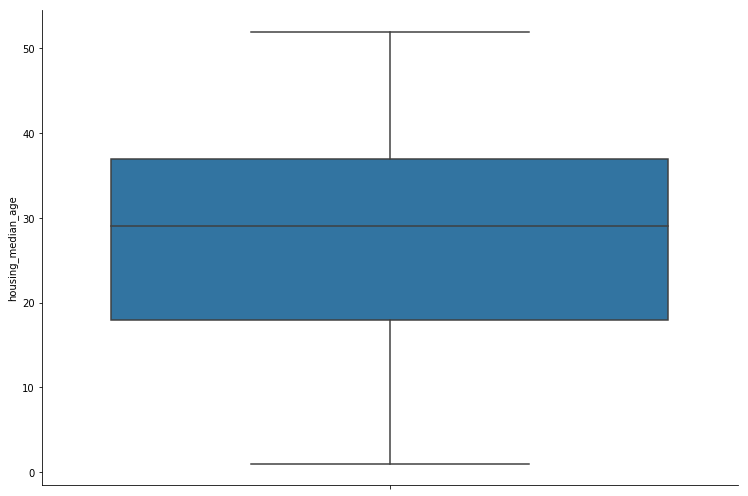

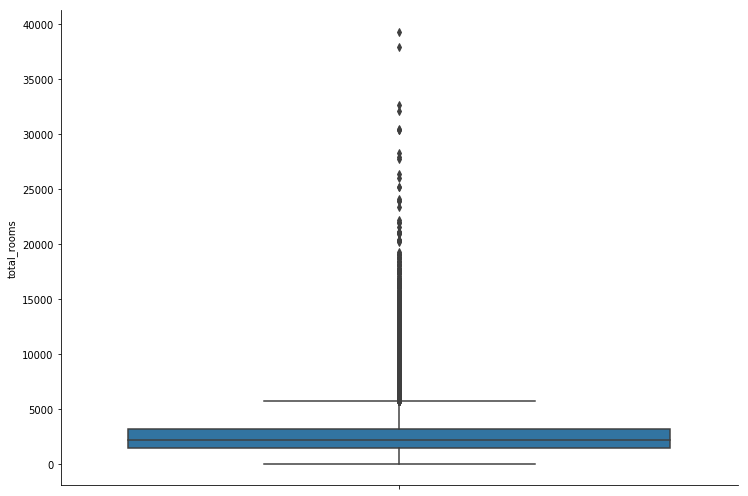

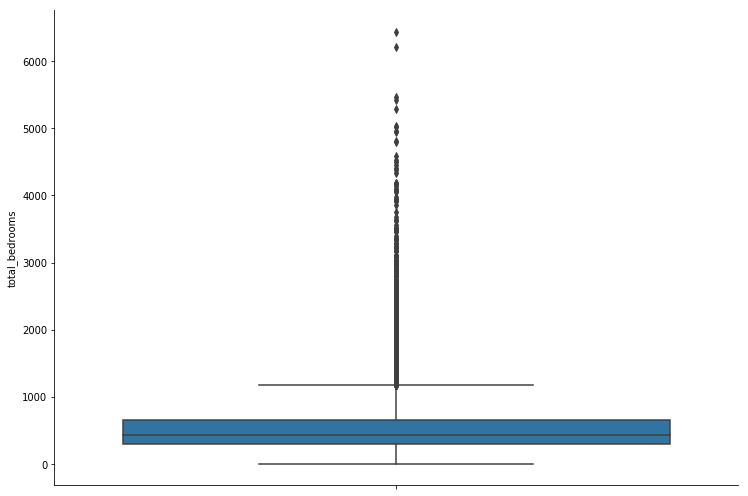

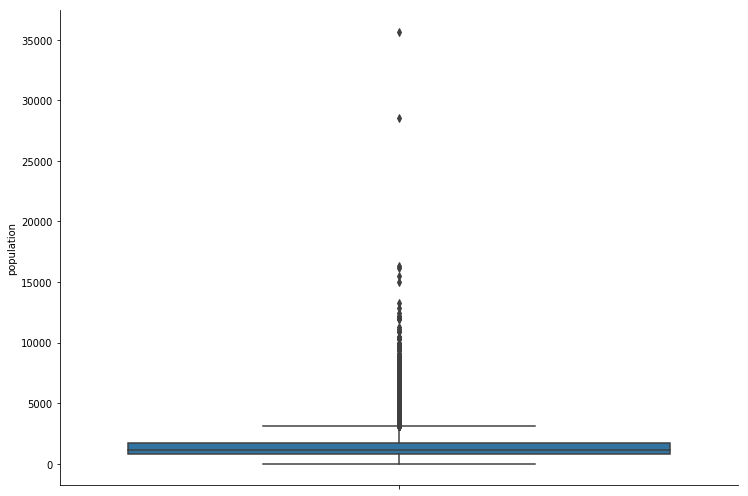

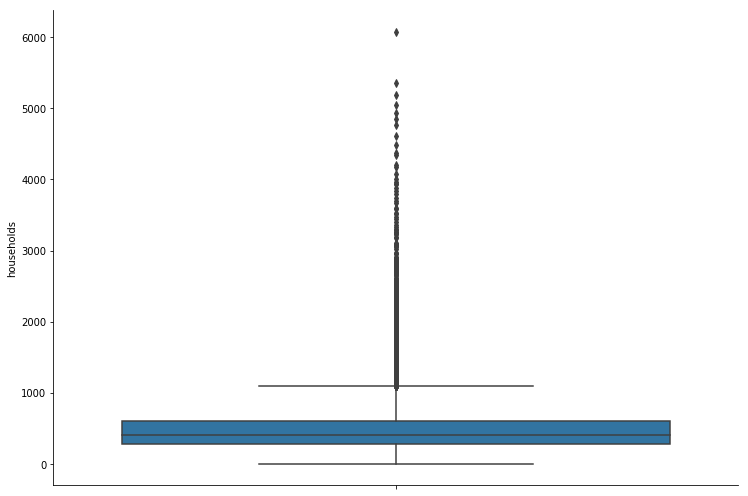

In [47]:
for i in df.columns:
    sns.factorplot(kind='box',
                   y=i,
                   data=df,
                   size=7,
                   aspect=1.5,
                   legend_out=False)

In [48]:
df[df.population > 15000]

,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households
6057,253900,6.0191,8,32054,5290,15507,5050
6066,339700,6.6288,7,27700,4179,15037,4072
9880,118800,2.3087,11,32627,6445,28566,6082
10309,366300,7.4947,4,37937,5471,16122,5189
13139,153700,4.9516,3,39320,6210,16305,5358
15360,134400,2.5729,14,25135,4819,35682,4769


In [49]:
df = df[df.population < 15000]

# Selección del modelo

In [51]:
df['ln_median_house_value'] = np.log(df.median_house_value)
df['ln_housing_median_age'] = np.log(df.housing_median_age)
df['ln_households'] = np.log(df.households)

df['median_income_2'] = df.median_income ** 2
df['median_income_3'] = df.median_income ** 3

df['ln_trooms_popul'] = np.log(df.total_rooms/df.population)
df['ln_tbedrooms_popul'] = np.log(df.total_bedrooms/df.population)
df['ln_popul_households'] = np.log(df.population/df.households)

In [52]:
df.head()

,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,ln_median_house_value,ln_housing_median_age,ln_households,median_income_2,median_income_3,ln_trooms_popul,ln_tbedrooms_popul,ln_popul_households
0,452600,8.3252,41,880,129,322,126,13.022764,3.713572,4.836282,69.308955,577.010912,1.005370,-0.914739,0.938270
1,358500,8.3014,21,7099,1106,2401,1138,12.789684,3.044522,7.037028,68.913242,572.076387,1.084069,-0.775135,0.746613
2,352100,7.2574,52,1467,190,496,177,12.771671,3.951244,5.176150,52.669855,382.246204,1.084399,-0.959552,1.030426
3,341300,5.6431,52,1274,235,558,219,12.740517,3.951244,5.389072,31.844578,179.702136,0.825558,-0.864773,0.935287
4,342200,3.8462,52,1627,280,565,259,12.743151,3.951244,5.556828,14.793254,56.897815,1.057667,-0.702036,0.779998


In [54]:
df_model = df[['ln_median_house_value', 'median_income', 'median_income_2', 'median_income_3', 
               'ln_housing_median_age', 'ln_trooms_popul', 'ln_tbedrooms_popul', 
               'ln_popul_households', 'households']]
df_model.head()

,ln_median_house_value,median_income,median_income_2,median_income_3,ln_housing_median_age,ln_trooms_popul,ln_tbedrooms_popul,ln_popul_households,households
0,13.022764,8.3252,69.308955,577.010912,3.713572,1.005370,-0.914739,0.938270,126
1,12.789684,8.3014,68.913242,572.076387,3.044522,1.084069,-0.775135,0.746613,1138
2,12.771671,7.2574,52.669855,382.246204,3.951244,1.084399,-0.959552,1.030426,177
3,12.740517,5.6431,31.844578,179.702136,3.951244,0.825558,-0.864773,0.935287,219
4,12.743151,3.8462,14.793254,56.897815,3.951244,1.057667,-0.702036,0.779998,259


# 6. Separación de datos de entrenamiento y prueba <a class="anchor" id="train-test"></a>

In [55]:
from sklearn.model_selection import train_test_split

<br>
Separamos los datos en entrenamiento y prueba (33%) del conjunto de datos completo.

In [56]:
df_X = df_model.loc[:, df_model.columns != 'ln_median_house_value']
df_y = df_model.ln_median_house_value

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y,
                                                    test_size = 0.30, 
                                                    random_state = 1234)

In [57]:
print("X_train: " + str(X_train.shape))
print("X_test:  " + str(X_test.shape))
print("y_train: " + str(y_train.shape))
print("y_test:  " + str(y_test.shape))

X_train: (14443, 8)
X_test:  (6191, 8)
y_train: (14443,)
y_test:  (6191,)


# 7. Regresión lineal <a class="anchor" id="regresion-lineal"></a>

In [58]:
from sklearn.linear_model import LinearRegression

### Regresión lineal básica <a class="anchor" id="regresion-lineal-basica"></a>

In [59]:
reg_LR = LinearRegression(normalize=True)
reg_LR_fit = reg_LR.fit(X_train, y_train)
y_pred_LR = reg_LR.predict(X_test)

In [60]:
print('Intercept: ', reg_LR.intercept_)
print('Coefficients: ', reg_LR.coef_)

Intercept:  11.7495687647
Coefficients:  [  4.67643967e-01  -1.47733560e-02  -2.55682018e-04   1.61368484e-01
  -8.54834421e-01   7.90789272e-01  -4.34042419e-01   9.37869232e-05]


In [61]:
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_LR))
print('Variance score: %.2f' % r2_score(y_test, y_pred_LR))

Mean squared error: 0.13
Variance score: 0.61


### Regresión lineal con variables polinomiales <a class="anchor" id="regresion-lineal-polinomial"></a>

In [62]:
poly = PolynomialFeatures()
scaler = MinMaxScaler()
lin_reg = LinearRegression(normalize=True)

## Pipeline steps
polynomial_step = ('poly', poly)
scaler_step = ('scaler', scaler)
lin_reg_step = ('lin_reg_step', lin_reg)
steps = [polynomial_step, scaler_step, lin_reg_step]
pipe = Pipeline(steps)

tuned_parameters = {'poly__degree': [2, 3, 4]}

kfold = KFold(n_splits = 5)

gs_lin_reg = GridSearchCV(pipe, tuned_parameters, cv=kfold, n_jobs=-1)
gs_lin_reg.fit(X_train, y_train)

y_pred_lin_reg = gs_lin_reg.predict(X_test)

print("Best params: ", gs_lin_reg.best_params_)
print('\n')
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_lin_reg))
print('Variance score: %.2f' % r2_score(y_test, y_pred_lin_reg))

Best params:  {'poly__degree': 2}


Mean squared error: 0.12
Variance score: 0.65


# 9. Árboles de decisión <a class="anchor" id="arboles-decision"></a>

Los árboles de decisión son algoritmos de aprendizaje supervisado donde es posible visualizar el árbol de decisión entrenado, por lo que la interpretación de los resultados es más fácil. La forma en la que se genera un árbol de decisión es cogiendo el mejor atributo del conjunto de datos y situándolo en la *raíz* del árbol, para hacer un *split* y obtener un subconjunto de datos más pequeño. Posteriormente, se realizan estos mismos pasos en cada subconjunto de datos hasta encontrar los *nodos hoja* en cada una de las ramas del árbol.

Los árboles de decisión, aunque son fácilmente interpretables, sufren por tener una alta varianza y un pequeño cambio en los datos, puede cambiar el resultado final del árbol. Por este motivo, también se han realizado modelos con **Bagging**, **Random Forest** y **Boosting**, que veremos más adelante.

In [68]:
from sklearn.tree import DecisionTreeRegressor

### Árbol de decisión básico <a class="anchor" id="arbol-decision-basico"></a>

En este caso probamos un árbol de decisión sin modificar ningún parámetro y empleando las variables del PCA.

In [79]:
scaler = MinMaxScaler()
reg_DT = DecisionTreeRegressor()

scaler_step = ('scaler', scaler)
reg_DT_step = ('reg_DT', reg_DT)
steps = [scaler_step, reg_DT_step]
pipe = Pipeline(steps)

pipe.fit(X_train, y_train)
y_pred_reg_DT = pipe.predict(X_test)

print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_reg_DT))
print('Variance score: %.2f' % r2_score(y_test, y_pred_reg_DT))

Mean squared error: 0.21
Variance score: 0.37


In [80]:
reg_DT.tree_.max_depth

37

<br>
Se observa que el error cuadrático medio es muy alto, el valor R2 da negativo y la profundidad del árbol es de 43. Esto nos quiere decir que se está realizando un **Overfitting** sobre los datos de entrenamiento que hacen imposible predecir correctamente los datos de prueba. Por este motivo, es recomendable hacer un *GridSearchCV* para encontrar la profundidad máxima que ha de tener el árbol y el número mínimo de muestras necesarias para hacer un *split* o generar una hoja del árbol.

### Árbol de decisión mediante GridSearch <a class="anchor" id="arbol-decision-gridsearch"></a>

In [83]:
scaler = MinMaxScaler()
reg_DT_gscv = DecisionTreeRegressor()

scaler_step = ('scaler', scaler)
reg_DT_gscv_step = ('reg_DT_gscv', reg_DT_gscv)
steps = [scaler_step, reg_DT_gscv_step]
pipe = Pipeline(steps)

params = {'reg_DT_gscv__max_depth': range(5, 20),
          'reg_DT_gscv__min_samples_split': range(2, 15),
          'reg_DT_gscv__min_samples_leaf': range(2, 36, 2)}

kfold = KFold(n_splits = 3)

gs_reg_DT = GridSearchCV(pipe, param_grid=params, cv=kfold, n_jobs=-1)
gs_reg_DT.fit(X_train, y_train)

y_pred_reg_DT = gs_reg_DT.predict(X_test)

print("Best params: ", gs_reg_DT.best_params_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_reg_DT))
print('Variance score: %.2f' % r2_score(y_test, y_pred_reg_DT))

Best params:  {'reg_DT_gscv__min_samples_split': 9, 'reg_DT_gscv__max_depth': 10, 'reg_DT_gscv__min_samples_leaf': 26}
Mean squared error: 0.12
Variance score: 0.62


<br>
Vemos que la máxima profundidad que requiere el árbol es de 3, lo que quiere decir que encuentra muy pocas variables como importantes. Por este motivo, vamos a estudiar a continuación qué variables son las más importantes para el árbol generado y cómo es este árbol. Además, vemos que nos ha mejorado el error cuadrático medio, aunque únicamente en una centésima.

### Visualización de las variables más importantes <a class="anchor" id="arbol-decision-variables"></a>

A partir de los mejores parámetros para el árbol encontrados en el anterior *GridSearchCV*, generamos el árbol.

In [72]:
reg_DT = DecisionTreeRegressor(max_depth = gs_reg_DT.best_params_['max_depth'], 
                               min_samples_leaf = gs_reg_DT.best_params_['min_samples_leaf'], 
                               min_samples_split = gs_reg_DT.best_params_['min_samples_split'])
reg_DT.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=26,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

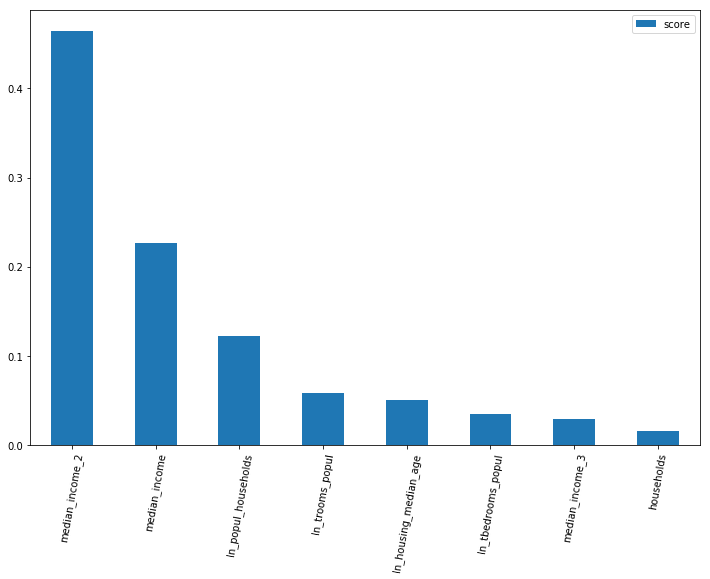

In [73]:
feat = pd.DataFrame(index=X_train.keys(), data=reg_DT.feature_importances_, columns=['score'])
feat = feat.sort_values(by='score', ascending=False)

feat.plot(kind='bar', rot=80)

La variable más importante para el árbol es la cuota del equipo local de la casa de apuestas *Bet365*, que será la raíz del árbol. Seis variables más tiene en cuenta el árbol, que son básicamente cuotas para el equipo local o para el empate, lo cual tiene sentido, ya que estamos intentando predecir los goles que mete el equipo que juega como local.

# 10. Bagging <a class="anchor" id="bagging"></a>

Bagging, o *Bootstrap Aggregation*, es un procedimiento de propósito general para reducir la varianza de un método de aprendizaje estadístico. Hay que tener en cuenta que dado un conjunto de *n* observaciones $Z_1, ..., Z_n$, cada una con varianza $\sigma^2$, la varianza de la media $\overline{Z}$ de las observaciones está dada por $\sigma^2 / n$, es decir, con el promedio del conjunto de observaciones se reduce la varianza. 

Por lo tanto, Bagging utiliza Bootstrap para coger varias muestras de un único conjunto de entrenamiento y así generar *B* conjuntos de entrenamientos de *Boostrap*. Gracias a esto, y en combinación con los árboles de decisión, genera *B* árboles de decisión y hace el promedio del resultado de las predicciones reduciendo la varianza.

In [74]:
from sklearn.ensemble import BaggingRegressor

In [75]:
bag_reg_DT = BaggingRegressor(DecisionTreeRegressor())

tuned_parameters = {'n_estimators': range(250, 450, 10)}
kfold = KFold(n_splits = 5)

gs_bag_reg_DT = GridSearchCV(bag_reg_DT, tuned_parameters, cv=kfold, n_jobs=-1)
gs_bag_reg_DT.fit(X_train, y_train)

y_pred_bag_reg_DT = gs_bag_reg_DT.predict(X_test)

print("Best params: ", gs_bag_reg_DT.best_params_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_bag_reg_DT))
print('Variance score: %.2f' % r2_score(y_test, y_pred_bag_reg_DT))

Best params:  {'n_estimators': 330}
Mean squared error: 0.11
Variance score: 0.68


<br>
Observamos que ha empeorado el error cuadrático medio con respecto a los otros modelos. Esto podría deberse a que para ciertos árboles, se están cogiendo muestras de variables con alta varianza y poco correlacionadas con la variable a predecir, lo que provocaría que algunos árboles dieran un error cuadrático medio por encima de los demás árboles y el promedio total se elevara.

# 11. Random Forest <a class="anchor" id="random-forest"></a>

Random Forest provee una mejora sobre los árboles de decisión de Bagging para reducir más la varianza. Esto se hace de modo que cada vez que se hace una división en un árbol, se considera una selección aleatoria de *m* predictores elegidos como candidatos de división de todo el conjunto de *p* predictores. 

Normalmente se usa $m = \sqrt{p}$, lo cual se refleja en el siguiente algoritmo mediante el parámetro **max_features = 'sqrt'**, aunque también se busca si con **max_features = 'auto'**, que es $m = p$ mejora el resultado. Además, con el parámetro **n_estimators** indicamos el número de árboles que se generan y con **max_depth** la profundidad de cada árbol. Estimamos la mejor combinación de estos parámetros mediante *GridSearchCV*.

In [76]:
from sklearn.ensemble import RandomForestRegressor

In [78]:
rand_for_reg = RandomForestRegressor()

tuned_parameters = {'n_estimators': range(120, 220, 10),
                    'max_features': ['sqrt', 'auto'],
                    'max_depth': range(7, 18, 2)}
kfold = KFold(n_splits = 3)

gs_rand_for_reg = GridSearchCV(rand_for_reg, tuned_parameters, cv=kfold, n_jobs=-1)
gs_rand_for_reg.fit(X_train, y_train)

y_pred_rand_for_reg = gs_rand_for_reg.predict(X_test)

print("Best params: ", gs_rand_for_reg.best_params_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_rand_for_reg))
print('Variance score: %.2f' % r2_score(y_test, y_pred_rand_for_reg))

KeyboardInterrupt: 

Vemos que la profundidad de los árboles es más alto que la del árbol de decisión básico generado anteriormente. Esto puede ser debido a que se cogen los predictores al azar y cada árbol puede estar tomando como importantes otros predictores que el árbol de decisión básico no había tenido en cuenta.

Hasta el momento, es el mejor modelo para predecir la variable **FTHG**.

### Visualización de las variables más importantes <a class="anchor" id="random-forest-variables"></a>

A continuación, comprobamos cuáles son las variables que ha encontrado más importantes para generar los árboles aleatorios.

In [95]:
rand_for_reg = RandomForestRegressor(max_depth = gs_rand_for_reg.best_params_['max_depth'], 
                                     max_features = gs_rand_for_reg.best_params_['max_features'], 
                                     n_estimators = gs_rand_for_reg.best_params_['n_estimators'])
rand_for_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=170, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

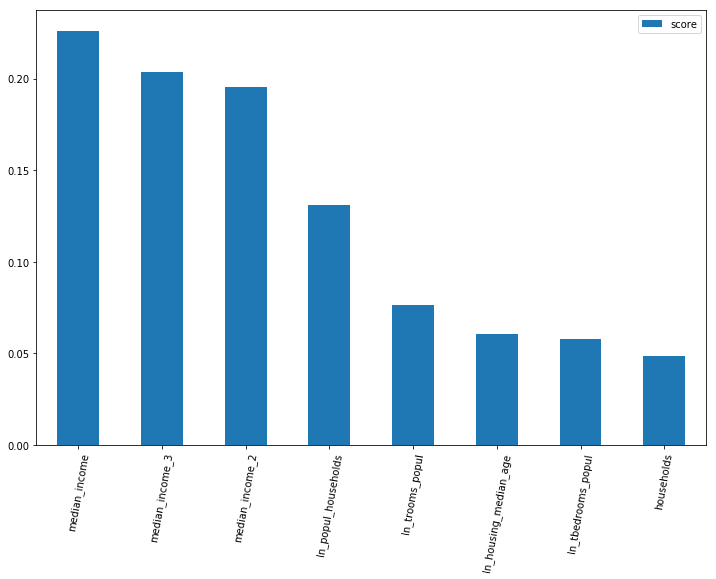

In [96]:
feat = pd.DataFrame(index=X_train.keys(), data=rand_for_reg.feature_importances_, columns=['score'])
feat = feat.sort_values(by='score', ascending=False)

feat[:25].plot(kind='bar', rot=80)

<br>
Observamos que ha cogido como importantes más variables que el árbol de decisión básico generado anteriormente, repartiendo el *score* entre todas ellas y no centrándolo mayoritariamente en una única variable. Las variables más importantes, no obstante, siguen siendo las cuotas para los equipos que juegan como local y los empates, aunque sí se puede apreciar como ha tenido en cuenta algunas variables de las cuotas de los equipos visitantes.

# 12. Boosting <a class="anchor" id="boosting"></a>

Así como Bagging implica la creación de múltiples copias del conjunto de entrenamiento original utilizando bootstrap, estimando un árbol de decisión independiente para cada copia, y luego combinando todos los árboles con el fin de crear un único modelo predictivo, Boosting hace que los árboles crezcan de forma secuencial, es decir, cada árbol crece utilizando la información de los árboles generados previamente.

In [97]:
from sklearn.ensemble import AdaBoostRegressor

In [101]:
ada_boost_reg = AdaBoostRegressor(DecisionTreeRegressor())

tuned_parameters = {'n_estimators': range(250, 450, 10)}
kfold = KFold(n_splits = 3)

gs_ada_boost_reg = GridSearchCV(ada_boost_reg, tuned_parameters, cv=kfold, n_jobs=-1)
gs_ada_boost_reg.fit(X_train, y_train)

y_pred_ada_boost_reg = gs_ada_boost_reg.predict(X_test)

print("Best params: ", gs_ada_boost_reg.best_params_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_ada_boost_reg))
print('Variance score: %.2f' % r2_score(y_test, y_pred_ada_boost_reg))

Best params:  {'n_estimators': 360}
Mean squared error: 0.11
Variance score: 0.65


Observamos que es un modelo que precide peor en comparación a los demás. Posiblemente sea por el mismo motivo explicado en el Bagging.

# SVM

### Kernel linear

In [103]:
from sklearn.svm import SVR

In [124]:
scaler = MinMaxScaler()
svr_lin_reg = SVR(kernel='linear', 
                  shrinking=True, 
                  cache_size=4096, 
                  max_iter=1000000)

scaler_step = ('scaler', scaler)
svr_lin_reg_step = ('svr_lin_reg', svr_lin_reg)
steps = [scaler_step, svr_lin_reg_step]
pipe = Pipeline(steps)

c = [0.001, 0.01, 0.1, 1, 5, 10]
epsilon = [0.001, 0.01, 0.1, 1]

tuned_parameters = {'svr_lin_reg__C': c, 
                    'svr_lin_reg__epsilon': epsilon}

kfold = KFold(n_splits = 3)

gs_svr_lin_reg = GridSearchCV(pipe, tuned_parameters, cv=kfold, n_jobs=-1)
gs_svr_lin_reg.fit(X_train, y_train)

y_pred_svr_lin_reg = gs_svr_lin_reg.predict(X_test)

print("Best params: ", gs_svr_lin_reg.best_params_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_svr_lin_reg))
print('Variance score: %.2f' % r2_score(y_test, y_pred_svr_lin_reg))

Best params:  {'svr_lin_reg__epsilon': 0.1, 'svr_lin_reg__C': 5}
Mean squared error: 0.13
Variance score: 0.60


### Kernel RBF

In [132]:
scaler = MinMaxScaler()
svr_rbf_reg = SVR(kernel='rbf', 
                  shrinking=True, 
                  cache_size=4096, 
                  max_iter=1000000)

scaler_step = ('scaler', scaler)
svr_rbf_reg_step = ('svr_rbf_reg', svr_rbf_reg)
steps = [scaler_step, svr_rbf_reg_step]
pipe = Pipeline(steps)

c = [0.001, 0.01, 0.1, 1, 5, 10]
gamma = [0.001, 0.01, 0.1, 1, 10]
epsilon = [0.001, 0.01, 0.1, 1]

tuned_parameters = {'svr_rbf_reg__C': c, 
                    'svr_rbf_reg__gamma': gamma, 
                    'svr_rbf_reg__epsilon': epsilon}

kfold = KFold(n_splits = 3)

gs_svr_rbf_reg = GridSearchCV(pipe, tuned_parameters, cv=kfold, n_jobs=-1)
gs_svr_rbf_reg.fit(X_train, y_train)

y_pred_svr_rbf_reg = gs_svr_rbf_reg.predict(X_test)

print("Best params: ", gs_svr_rbf_reg.best_params_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_svr_rbf_reg))
print('Variance score: %.2f' % r2_score(y_test, y_pred_svr_rbf_reg))

Best params:  {'svr_rbf_reg__gamma': 10, 'svr_rbf_reg__C': 10, 'svr_rbf_reg__epsilon': 0.1}
Mean squared error: 0.11
Variance score: 0.66


### Kernel poly

In [133]:
scaler = MinMaxScaler()
svr_ps_reg = SVR(kernel='poly', 
                  shrinking=True, 
                  cache_size=2048, 
                  max_iter=1000000)

scaler_step = ('scaler', scaler)
svr_ps_reg_step = ('svr_ps_reg', svr_ps_reg)
steps = [scaler_step, svr_ps_reg_step]
pipe = Pipeline(steps)

c = [0.001, 0.01, 0.1, 1, 5, 10]
gamma = [0.001, 0.01, 0.1, 1, 10]
degree = [2, 3]
epsilon = [0.001, 0.01, 0.1, 1]

tuned_parameters = {'svr_ps_reg__C': c, 
                    'svr_ps_reg__gamma': gamma,
                    'svr_ps_reg__degree': degree, 
                    'svr_ps_reg__epsilon': epsilon}

kfold = KFold(n_splits = 3)

gs_svr_ps_reg = GridSearchCV(pipe, tuned_parameters, cv=kfold, n_jobs=-1, verbose=True)
gs_svr_ps_reg.fit(X_train, y_train)

y_pred_svr_ps_reg = gs_svr_ps_reg.predict(X_test)

print("Best params: ", gs_svr_ps_reg.best_params_)
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred_svr_ps_reg))
print('Variance score: %.2f' % r2_score(y_test, y_pred_svr_ps_reg))

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.5min
/home/joan/.virtualenvs/MADM-2017/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/joan/.virtualenvs/MADM-2017/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/joan/.virtualenvs/MADM-2017/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/joan/.virtualenvs/MADM-2017/lib/python3.5/site-packages/sklearn/svm/base.py:218: Conver

/home/joan/.virtualenvs/MADM-2017/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/joan/.virtualenvs/MADM-2017/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/joan/.virtualenvs/MADM-2017/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/joan/.virtualenvs/MADM-2017/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxSca

/home/joan/.virtualenvs/MADM-2017/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/joan/.virtualenvs/MADM-2017/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/joan/.virtualenvs/MADM-2017/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/joan/.virtualenvs/MADM-2017/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxSca

/home/joan/.virtualenvs/MADM-2017/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 14.7min finished
/home/joan/.virtualenvs/MADM-2017/lib/python3.5/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Best params:  {'svr_ps_reg__degree': 3, 'svr_ps_reg__gamma': 1, 'svr_ps_reg__C': 10, 'svr_ps_reg__epsilon': 0.1}
Mean squared error: 0.12
Variance score: 0.64


# Redes neuronales

In [ ]:
from sklearn.neural_network import MLPRegressor